[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
VIX Data:
                 Open       High        Low      Close  Adj Close  Volume
Date                                                                     
2018-10-26  24.510000  27.520000  23.330000  24.160000  24.160000       0
2018-10-29  24.480000  27.860001  22.010000  24.700001  24.700001       0
2018-10-30  23.940001  25.549999  23.110001  23.350000  23.350000       0
2018-10-31  22.719999  22.799999  20.389999  21.230000  21.230000       0
2018-11-01  20.959999  21.209999  19.030001  19.340000  19.340000       0

S&P 500 Data:
                  Open        High         Low       Close   Adj Close  \
Date                                                                     
2018-10-26  265.920013  271.000000  262.290009  265.329987  244.085175   
2018-10-29  268.799988  270.250000  259.850006  263.859985  242.732864   
2018-10-30  263.670013 

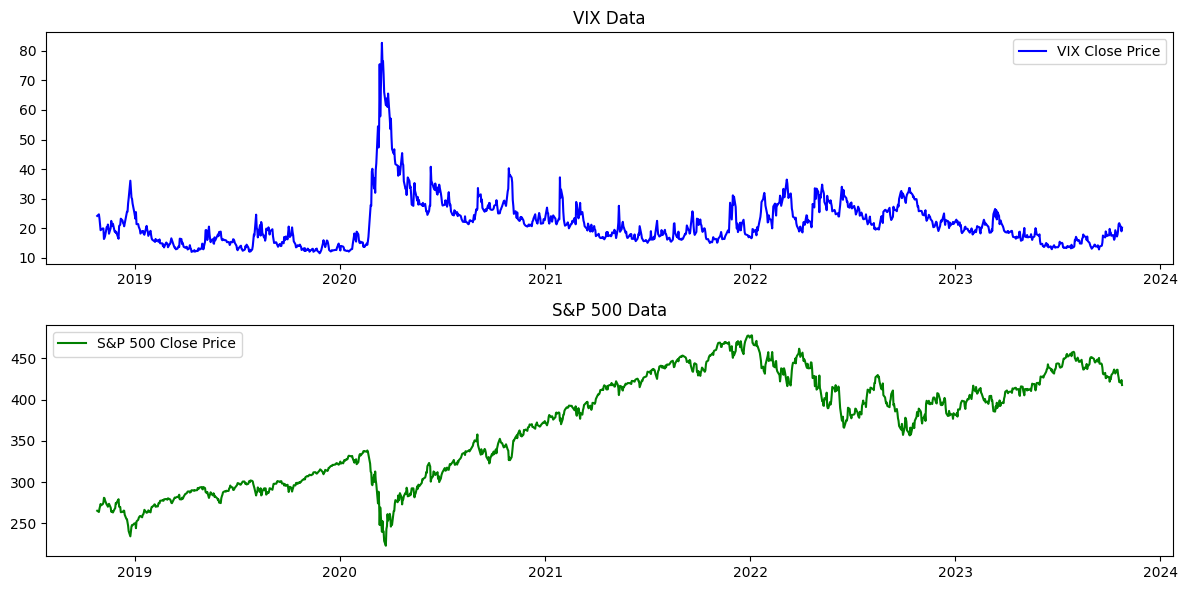

In [1]:
import yfinance as yf
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.feature_selection import SelectKBest, f_regression, RFE
from sklearn.model_selection import train_test_split, TimeSeriesSplit, RandomizedSearchCV

# Define the ticker symbols for VIX and S&P 500
vix_ticker = "^VIX"  # VIX
sp500_ticker = "SPY"  # S&P 500

# Define the date range for the last 5 years
end_date = "2023-10-26"
start_date = "2018-10-26"

# Download data from Yahoo Finance
vix_data = yf.download(vix_ticker, start=start_date, end=end_date)
sp500_data = yf.download(sp500_ticker, start=start_date, end=end_date)

# Display the first few rows of the data
print("VIX Data:")
print(vix_data.head())

print("\nS&P 500 Data:")
print(sp500_data.head())

# Handle missing data
vix_data.dropna(inplace=True)
sp500_data.dropna(inplace=True)

# Remove duplicates, if any
vix_data = vix_data[~vix_data.index.duplicated(keep="first")]
sp500_data = sp500_data[~sp500_data.index.duplicated(keep="first")]

# Display the first few rows of the cleaned data
print("\nCleaned VIX Data:")
print(vix_data.head())

print("\nCleaned S&P 500 Data:")
print(sp500_data.head())

# Visualize the data
plt.figure(figsize=(12, 6))
plt.subplot(2, 1, 1)
plt.title("VIX Data")
plt.plot(vix_data['Close'], label='VIX Close Price', color='b')
plt.legend()

plt.subplot(2, 1, 2)
plt.title("S&P 500 Data")
plt.plot(sp500_data['Close'], label='S&P 500 Close Price', color='g')
plt.legend()

plt.tight_layout()
plt.show()


In [2]:
# Calculate the price difference for VIX (VIX data)
vix_data['VIX_Price_Diff'] = vix_data['Close'].diff()

# Calculate the price returns for S&P 500 (SP500 data)
sp500_data['SP500_Return'] = sp500_data['Close'].pct_change()
sp500_data['SP500_Return_Squared'] = sp500_data['Close'].pct_change()**2

data = pd.concat([sp500_data[['SP500_Return','SP500_Return_Squared']],vix_data['VIX_Price_Diff']],axis=1)
data_shift = pd.concat([sp500_data[['SP500_Return','SP500_Return_Squared']].shift(1),vix_data['VIX_Price_Diff']],axis=1)


# Drop rows since that have a NaN value for returns
data = data.dropna()
data_shift = data_shift.dropna()

list_data = [[data,'non_shifted'],[data_shift,'shifted']]

print(data.head())
print(data_shift.head())

            SP500_Return  SP500_Return_Squared  VIX_Price_Diff
Date                                                          
2018-10-29     -0.005540              0.000031        0.540001
2018-10-30      0.014818              0.000220       -1.350000
2018-10-31      0.010681              0.000114       -2.120001
2018-11-01      0.010642              0.000113       -1.889999
2018-11-02     -0.005923              0.000035        0.170000
            SP500_Return  SP500_Return_Squared  VIX_Price_Diff
Date                                                          
2018-10-30     -0.005540              0.000031       -1.350000
2018-10-31      0.014818              0.000220       -2.120001
2018-11-01      0.010681              0.000114       -1.889999
2018-11-02      0.010642              0.000113        0.170000
2018-11-05     -0.005923              0.000035        0.449999


In [3]:
X_train, X_test, y_train, y_test = train_test_split(sp500_data, vix_data, test_size=0.2, shuffle=False)

In [4]:
from scipy.optimize import curve_fit
import numpy as np
# Compute R2 and MSE
from sklearn.metrics import r2_score, mean_squared_error

# Define the function you want to fit
def model(x, alpha, beta, gamma):
    return alpha + beta * x + gamma * x**2

def curve_fitter(X_train,X_test,y_train,y_test):
    # Fit the model to the data
    initial_alpha = 0.0
    initial_beta = 0.0
    initial_gamma = 0.0
    p0 = [initial_alpha, initial_beta, initial_gamma]  # Initial parameter guesses
    params, covariance = curve_fit(model, X_train['SP500_Return'], y_train, p0=p0)

    # The optimized parameters
    alpha_opt, beta_opt, gamma_opt = params

    # Display the optimized parameters
    print("Optimized Parameters:")
    print("Alpha:", alpha_opt)
    print("Beta:", beta_opt)
    print("Gamma:", gamma_opt)

    # Make predictions with the optimized parameters
    y_pred = model(X_test['SP500_Return'], alpha_opt, beta_opt, gamma_opt)

    r2 = r2_score(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    residual_std = (y_pred-y_test).std() 

    print("R-squared (R2):", r2)
    print("Mean Squared Error (MSE):", mse)
    
    return r2,mse,rmse,residual_std

In [5]:
import xgboost as xgb

def xgboost_hedge(X_train, X_test, y_train, y_test):
    """
    Perform hedging using XGBoost.

    Parameters:
    - X (pandas.DataFrame): Feature data for hedging.
    - y (pandas.Series): Target data for hedging.

    Returns:
    - feature_importances (ndarray): Feature importances from XGBoost.
    """
    tscv = TimeSeriesSplit(n_splits=5)
    param_grid = {
        'n_estimators': [100, 200, 300],
        'max_depth': [3, 4, 5],
        'learning_rate': [0.01, 0.1, 0.2],
        'subsample': [0.8, 0.9, 1.0],
        'colsample_bytree': [0.8, 0.9, 1.0]
    }

    xgb_regressor = xgb.XGBRegressor()
    random_search = RandomizedSearchCV(
        xgb_regressor, param_distributions=param_grid, n_iter=10, scoring='neg_mean_squared_error',
        cv=tscv, n_jobs=-1, random_state=42
    )

    random_search.fit(X_train, y_train)
    best_model = random_search.best_estimator_
    y_pred = best_model.predict(X_test)

    best_params = random_search.best_params_
    feature_importances = best_model.feature_importances_

    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    rmse = np.sqrt(mse)
    residual_std = (y_pred-y_test).std()

    print("XGBoost feature importance : " + str(feature_importances))
    print("R-squared (R2):", r2)
    print("Mean Squared Error (MSE):", mse)

    return r2,mse,rmse,residual_std

In [7]:
# Initialize lists to store the results
regression_names = []
r2_list = []
mse_list = []
rmse_list = []
std_residual_list = []
for temp_list in list_data:
    name = temp_list[1]
    temp_data = temp_list[0]
    X_train, X_test, y_train, y_test = train_test_split(temp_data[['SP500_Return','SP500_Return_Squared']], temp_data['VIX_Price_Diff'], test_size=0.2, shuffle=False)
    
    r2,mse,rmse,residual_std = curve_fitter(X_train,X_test,y_train,y_test)
    regression_names.append('Curve_Fitter_' + name)
    r2_list.append(r2)
    mse_list.append(mse)
    rmse_list.append(rmse)
    std_residual_list.append(residual_std)
    r2,mse,rmse,residual_std = xgboost_hedge(X_train,X_test,y_train,y_test)
    regression_names.append('XGBoost_' + name)
    r2_list.append(r2)
    mse_list.append(mse)
    rmse_list.append(rmse)
    std_residual_list.append(residual_std)
    
#XGBoost non_quadratic
r2,mse,rmse,residual_std = xgboost_hedge(X_train['SP500_Return'],X_test['SP500_Return'],y_train,y_test)
regression_names.append('XGBoost_non_quadratic' + name)
r2_list.append(r2)
mse_list.append(mse)
rmse_list.append(rmse)
std_residual_list.append(residual_std)
    
# Create a summary DataFrame for the results
results_data = {
    'Regression_name': regression_names,
    'R2': r2_list,
    'MSE': mse_list,
    'RMSE': rmse_list,
    'Residual_std': std_residual_list
}
results_df = pd.DataFrame(results_data)

# Display the results
results_df

Optimized Parameters:
Alpha: -0.07263002490677828
Beta: -126.0553424229371
Gamma: 667.4486951779998
R-squared (R2): 0.2941649666598798
Mean Squared Error (MSE): 0.8234532521704158
XGBoost feature importance : [0.84193337 0.1580666 ]
R-squared (R2): 0.34826013842878656
Mean Squared Error (MSE): 0.7603438243073207
Optimized Parameters:
Alpha: -0.010045664354197384
Beta: 38.618037383541825
Gamma: -18.98233296180004
R-squared (R2): -0.11954490056923817
Mean Squared Error (MSE): 1.3031245456937899
XGBoost feature importance : [0.5396858  0.46031427]
R-squared (R2): -0.05084699579249974
Mean Squared Error (MSE): 1.2231617626854578
XGBoost feature importance : [1.]
R-squared (R2): -0.05726541336384017
Mean Squared Error (MSE): 1.230632653292412


,Regression_name,R2,MSE,RMSE,Residual_std
0,Curve_Fitter_non_shifted,0.294165,0.823453,0.907443,0.908960
1,XGBoost_non_shifted,0.348260,0.760344,0.871977,0.872319
2,Curve_Fitter_shifted,-0.119545,1.303125,1.141545,1.143119
3,XGBoost_shifted,-0.050847,1.223162,1.105966,1.082371
4,XGBoost_non_quadraticshifted,-0.057265,1.230633,1.109339,1.085638
